Integrantes:

- Juan Carlos Sánchez
- Nicolás Eduardo Pardo
- David Esteban Casallas

### Imports

In [ ]:
# Librerias
import random
import copy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time
import math
import pandas as pd
import concurrent.futures
import multiprocessing as mp

# Punto 1

Este cuaderno fue escrito en Python, pero dado el tiempo necesario para la ejecución de cada experimento en el interprete nativo de Python era excesivo, decidimos usar [PyPy](https://pypy.org). [PyPy](https://pypy.org) es una version "compilada" de python que hacer uso de un JIT(Just In Time Compiler) para acelerar la ejecución de bloques de códigos repetitivos como por ejemplo ciclos _for_. Esta característica es adecuada para la simulación de _Systematic Gibbs_ ya que el JIT puede optimizar la ejecución de cada paso. Esto permite reducir el tiempo de ejecución en hasta un 80%. Puede ejecutar este código de manera nativa en python, pero el rendimiento no va a ser optimo.
Adjunto a este cuaderno enviamos un _Dockerfile_ que le permitirá ejecutar fácilmente este cuaderno usando PyPy por medio de [Docker](https://docs.docker.com/desktop/install/windows-install/). Una vez instalado docker, ejecute:

```
    docker build . -t pypy
```
Este comando construirá la imagen con todos los requisitos del cuaderno, esto puede tardar según las especificaciones de su computador, ya que se compilan todas las librerías usadas.

Luego,
```
    docker run --rm -p 8888:8888 pypy
```
Esto le mostrara una URL para conectar Jupyter con el cuaderno.

---

Primero vamos a definir el _Systematic Gibbs_.

Para un cuadricula $G$, se recibe:
- $k$ el tamaño del _lattice_.
- $steps$ el numero de pasos.
- $edges$ el grafo de adyacencia.
- $q$ la cantidad de colores.

Retorna:
- $q$-coloración del _lattice_, obtenida después de $steps$ pasos.

In [ ]:
def sysGibbs(k, steps, edges, q):# k * k matriz, 'n' steps, conjunto de aristas, colores
  n = k * k
  g = []
  color = []
  # Inicializamos el grafo y los colores
  for i in range(n):
    g.append([])  # no tiene nodos adyacentes
    color.append(-1) # -1 para representar que el nodo no esta coloreado

  # Creamos el grafo con las aristas: Lista de adyacencias
  for e in edges:
    g[e[0]].append(e[1])
    g[e[1]].append(e[0])

  colors = []
  # Agregamos los 'q' colores
  for i in range(q):
    colors.append(i)

  # Hacemos los steps
  for u in range(steps):
    colors_av = colors.copy() # Definimos colores disponibles (available)
    for v in g[u % n]:
      if colors_av.count(color[v]) > 0:
        colors_av.remove(color[v]) # Removemos los colores usados
    it = random.randint(0,len(colors_av)-1) # Escogemos uno aleatorio
    color[u % n] = colors_av[it] # Asignamos el color

  return color

Creamos también una función para verificar que el lattice cumple con ser una $q$-coloración con la propiedad de que el color en los vertices de la arista $j$ sean distintos en el grafo $G_{j-1}$.

Recibe:
- $color$, la coloración del grafo $G_{j-1}$
- $edges$, la matriz de adyacencia de $G_{j-1}$.
- $j$, la arista que se agrega.
Retorna:
- Verdadero si los colores en los vertices de la arista $j$ son diferentes, falso en otro caso.

In [ ]:
def qColCheck(color, edges, j):
  return color[edges[j][0]] != color[edges[j][1]] # Se verifica si el color en esa arista es igual o no


Generamos todas las aristas para un lattice de tamaño $k \times k$ para de esa forma agregar una arista $j$ a la vez.

Recibe:
- $k \in \mathbb{N}$

Retorna:
- Matriz de adyacencia del _lattice_ de tamaño $k \times k$.

In [ ]:
def edgGen(k):
  edges = []
  n = k*k
  for i in range(n): # Pasamos por cada nodo
    if i % k == i : # Los primeros no tienen arista hacia arriba solo hacia la derecha
      if not (i % k == k-1): # El ultimo nodo de la primera fila no tiene arista hacia arriba ni a la derecha
        edges.append((i,i+1))
    elif (i % k == k-1): # El ultimo nodo de todas las filas excepto la primera tiene arista hacia arriba pero no a la derecha
      edges.append((i-k,i))
    else:                     # El resto de nodos tienen aristas a la derecha y arriba
      edges.append((i,i+1))
      edges.append((i-k,i))

  return edges

Para realizar el experimento primero vamos a tener en cuenta lo siguiente:

- El teorema nos dice que necesitamos no más de $48*(d^2) * (k^3)/(e^2)$ simulaciones y que cada simulación no requiere más de $k(2 * log(k)+log(e^-1)+log(8)/log(q/(2 * d^2))+1)$ pasos del Gibbs sampler.
- Fijemos primero epsilon como $0.1$, y note que como estamos trabajando en lattice tenemos que $d = 4$ para $k \geq 3$. Calculemos entonces los pasos que necesitaríamos para $k = 3$.
- Necesitamos entonces no más de $48*(4 * 4)*(9 * 9 * 9)/(0.1 * 0.1) = 55987200$. Estos son muchos pasos así que vamos a probar con otra cantidad.

Seria interesante ver como evoluciona esta aproximación a medida que aumentan los pasos en el _Systematic Gibbs_ y el numero de simulaciones. Para esto, definimos otras funciones:

`GenCheck`

Recibe:
 - $k$, tamaño del _lattice_.
 - $q$, colores para la coloración.
 - $steps$, numero de pasos para el _Systematic Gibbs_.
 - $sims$, numero de simulaciones para estimar $Z_{j}/Z_{j-1}$.
 - $edgb$, matriz de adyacencia de $G_{j-1}$.
 - $edga$, matriz de adyacencia de $G_{j}$.
 - $j$, vértice a ser añadido.

 Retorna:

 - Aproximación del promedio de grafos $G_{j-1}$ donde el color en los vertices de la arista $j$ sean distintos en el grafo $G_{j-1}$.



In [ ]:
def GenCheck(k, q, steps, sims, edgb, edga, j):
  valid = 0; # Llevamos el conteo de las muestras que pasan el test

  for _ in range(sims): # Realizamos las simulaciones
    if qColCheck(sysGibbs(k, steps, edgb, q), edga, j): # Generamos una muestra con unas aristas y la evaluamos con una arista adicional
      valid = valid + 1

  return valid/sims # Promedio de muestras que pasaron el test

Ya tenemos todos los ingredientes para hacer la una aproximación de el numero de $q$ coloraciones en el _lattice_ $k \times k$. Sin embargo, esta tarea puede tomar bastante tiempo si se ejecuta en un solo hilo. Existen varias etapas en esta simulación que se podrías ejecutar de paralelamente, sin embargo no todas las tareas se ajustan bien a una ejecución multi hilo, como se vera a continuación.

Los pasos que se podrían ejecutar paralelamente son:

1. Las $n$ simulaciones del _Systematic Gibbs_.
2. El calculo de cada $Z_{j}/Z_{j-1}$.

Nótese que en el primer caso, cada simulación acapararía un hilo, una vez este proceso finalice, se tendrá que hacer un cambio de contexto para ejecutar la nueva simulación, este cambio es bastante costoso y dado el numero de simulaciones necesarias puede que al aumento del rendimiento no sea el esperado.

En el segundo caso, como el numero de términos $Z_{j}/Z_{j-1}$ es mas reducido que el numero de simulaciones, los cambios de contexto serian menos y se podría aprovechar mejor de los multiples hilos de un computador.

En este caso tomaremos la segunda opción, pero primero miraremos como se comportan las simulaciones haciendo uno de uno y de varios hilos. Para esto, definimos:

`ExperimentSingleThreat`

Recibe:
 - $k$, tamaño del _lattice_.
 - $q$, colores para la coloración.
 - $steps$, numero de pasos para el _Systematic Gibbs_.
 - $sims$, numero de simulaciones para estimar $Z_{j}/Z_{j-1}$.

Retorna:
- $Z/Z_0$, con $Z$ el numero aproximado de $q$-coloraciones para el _lattice_ $k \times k$.

`ExperimentMultiThreat`. Esta función es igual que `ExperimentSingleThreat`, pero usa todos los hilos disponibles en el sistema.

In [ ]:
def ExperimentSingleThreat(k, q, steps, sims):
  m = 2*(k-1)*k # Calculamos cuantas aristas hay para saber la cantidad de generaciones
  edgf = edgGen(k) # Generamos las aristas del lattice
  prom = 1

  for i in range(m): # Pasos sobre las aristas
    prom = prom * GenCheck(k,q, steps, sims, edgf[0:i], edgf[0:i+1], i) # Se multiplica el resultado de las generaciones

  return prom

In [ ]:
def ExperimentMultiThreat(k, q, steps, sims):
  m = 2*(k-1)*k
  edgf = edgGen(k)
  prom = 1

  with concurrent.futures.ProcessPoolExecutor(max_workers=mp.cpu_count()) as executor:
    futures = [executor.submit(GenCheck, k, q, steps, sims, edgf[0:j], edgf[0:j+1], j) for j in range(m)]
    for future in concurrent.futures.as_completed(futures):
      try:
        prom = prom * future.result()
      except Exception as exc:
        print(f"Task generated an exception: {exc}")

    return prom

Como dijimos, la mejora del rendimiento no siempre es la esperada, para esto, simulemos los experimentos usando tanto un hilo como todos los disponibles, es este caso 16, y veamos como mejora o no el rendimiento. En este caso se hace una simulación de 5000 pasos en el _Systematic Gibbs_, para $0 \leq k,q\leq 10$.

In [ ]:
ml, s = 1, 1
for k in range(2, 10):
    for q in range(2, 10):
        start_time = time.time()
        ExperimentSingleThreat(k, q, 1, 5000)
        end_time = time.time()
        elapsed_time1 = end_time - start_time

        start_time = time.time()
        ExperimentMultiThreat(k, q, 1, 5000)
        end_time = time.time()
        elapsed_time2 = end_time - start_time
        diff = round(abs(elapsed_time2 - elapsed_time1)/elapsed_time1*100, 2)
        if elapsed_time1 < elapsed_time2:
            print(f'Gana 1 hilo k={k}, q={q}, {diff}, % mas lento')
            s += 1
        else:
            print(f'Gana multi hilo k={k}, q={q}, {diff}, % mas rapido')
            ml +=1
print(f'Un solo hilo gano: {s} y multihilo: {ml}')

Gana 1 hilo k=2, q=2, 511.07, % mas lento
Gana 1 hilo k=2, q=3, 534.84, % mas lento
Gana 1 hilo k=2, q=4, 221.19, % mas lento
Gana 1 hilo k=2, q=5, 1329.18, % mas lento
Gana 1 hilo k=2, q=6, 2115.31, % mas lento
Gana 1 hilo k=2, q=7, 1897.95, % mas lento
Gana 1 hilo k=2, q=8, 1524.16, % mas lento
Gana 1 hilo k=2, q=9, 1788.24, % mas lento
Gana 1 hilo k=3, q=2, 169.78, % mas lento
Gana 1 hilo k=3, q=3, 787.71, % mas lento
Gana 1 hilo k=3, q=4, 738.98, % mas lento
Gana 1 hilo k=3, q=5, 589.71, % mas lento
Gana 1 hilo k=3, q=6, 648.24, % mas lento
Gana 1 hilo k=3, q=7, 786.05, % mas lento
Gana 1 hilo k=3, q=8, 572.58, % mas lento
Gana 1 hilo k=3, q=9, 565.01, % mas lento
Gana 1 hilo k=4, q=2, 164.48, % mas lento
Gana 1 hilo k=4, q=3, 314.1, % mas lento
Gana 1 hilo k=4, q=4, 237.12, % mas lento
Gana 1 hilo k=4, q=5, 256.51, % mas lento
Gana 1 hilo k=4, q=6, 255.69, % mas lento
Gana 1 hilo k=4, q=7, 231.21, % mas lento
Gana 1 hilo k=4, q=8, 183.66, % mas lento
Gana 1 hilo k=4, q=9, 273.5, %

Notese que el cambio no se da en grafos pequeños, de hecho empeora visiblemente. Sin embargo en grafos con $k \geq 6$ y $q \geq 2$, hay una mejora. También hay que señalar que cuando $q$ y $k$, crecen, la diferencia también. Por ejemplo en el siguiente caso se hace la misma simulación pero con $k=q=20$ y con 100 simulaciones, en este caso la diferencia es notable, con una reducción del 62% en el tiempo de ejecución.

In [ ]:
start_time = time.time()
ExperimentSingleThreat(20, 20, 100, 5000)
end_time = time.time()
elapsed_time1 = end_time - start_time

start_time = time.time()
ExperimentMultiThreat(20, 20, 100, 5000)
end_time = time.time()
elapsed_time2 = end_time - start_time
print(f'Un solo hilo tomo: {elapsed_time1} y multihilo {elapsed_time2}')

Un solo hilo tomo: 129.56168675422668 y multihilo 49.609041929244995


Por esto, usaremos un solo hilo para grafos pequeños y varios hilos para grafos grandes, así definimos:

`Experiment`

Recibe:
 - $k$, tamaño del _lattice_.
 - $q$, colores para la coloración.
 - $steps$, numero de pasos para el _Systematic Gibbs_.
 - $sims$, numero de simulaciones para estimar $Z_{j}/Z_{j-1}$.

Retorna:

- $Z$ el numero aproximado de $q$-coloraciones para el _lattice_ $k \times k$.

In [ ]:
def Experiment(k, q, steps, sims):
    if(k >= 6 and q >= 2 ):
        return ExperimentMultiThreat(k, q, steps, sims)*(q**(k*k))
    else:
        return ExperimentSingleThreat(k, q, steps, sims)*(q**(k*k))

Vamos entonces a realizar un par de pruebas con el experimento que hemos creado, en la primera prueba vamos a comenzar desde $k \times k$ cantidad de pasos y 10 simulaciones. Luego vamos a utilizar una función que irá aumentando el tamaño de los pasos y las simulaciones y veremos en qué momento dejamos de obtener una mejora considerable.

Definimos `findConstQColor`.

Recibe:
 - $k$, tamaño del _lattice_.
 - $q$, colores para la coloración.
 - $amount$, numero de experimentos que queremos realizar.

 Retorna:
 - $tries$, $results$, listas con el numero de intentos (simulaciones $\times$ pasos) y el valor aproximado de $Z$, respectivamente.

In [ ]:
def findConstQColor(k, q, amount):
  flag = False
  const_1 = 1 # Iniciamos constantes en 1
  const_2 = 1


  steps = k*k  # Iniciamos la cantidad de pasos en k*k
  sims =  10   # Iniciamos la cantidad de simulaciones en 10

  tries = [] # Guardamos el total de pasos*simulaciones
  results = [] # Guardamos las aproximaciones

  while not flag:
    t_steps = steps + (const_1) # Aumentamos los pasos con una constante
    t_sims = sims + (const_2) # Aumentamos las simulaciones con otra constante

    tries.append(t_steps*t_sims)
    results.append(Experiment(k, q, t_steps, t_sims)) # Guardamos los resultados

    if len(tries) > amount: # Terminamos el experimento luego de una cantidad de pasos
      flag = True

    const_1 += 1 # Aumentamos las constantes
    const_2 += 2

  return tries, results


Para evidenciar mejor lo que sucede vamos graficar los resultados aproximados, note que la mejor aproximación será el resultado de un promedio de resultados individuales. Es decir se tomaran 20 valores y se promediaran para estudiar mejor el acercamiento de los resultados al valor real.

`GraphQColorTest`

Recibe:

 - $k$, tamaño del _lattice_.
 - $q$, colores para la coloración.
 - $teo$, valor teórico de la $q$-coloración.
 - $error$, el error o epsilon.
 - $ylimit$, lista con el máximo y el mínimo para el eje $y$ de la gráfica.
 - $calback$, la función que se usará para obtener el _dataframe_ de los las simulaciones.

 Retorna:

 - Gráfica que muestra la evolución de la simulación a medida que se aumentan el numero de simulaciones y de pasos del _Systematic Gibss_.

In [ ]:
def GraphQColorTest(k, q, amount, teo = None, error = None, ylimit = None, callback = findConstQColor):
  x, y = callback(k, q, amount) #Guardamos los resultados y las cantidades de pasos y simulaciones en una base de datos


  df = pd.DataFrame({'Const':x, 'Aproximación':y})
  df['Promedio móvil'] = df['Aproximación'].rolling(window=20).mean() # Calculamos el promedio con una cantidad de 20 puntos

  df.plot(x='Const', y=['Aproximación', 'Promedio móvil'], figsize=(20,5), color=['cornflowerblue', 'blueviolet']) # Graficamos


  if error:
    plt.axhline(y = teo, color = 'r', linestyle = '-', alpha = 0.5)
    plt.axhline(y = teo+(error*teo), color = 'g', linestyle = '-', alpha = 0.5) #Con esto podemos visualizar el valor teórico y sus cotas de error
    plt.axhline(y = teo-(error*teo), color = 'g', linestyle = '-', alpha = 0.5)

  if ylimit:
    plt.ylim(*ylimit)
  plt.xlabel('Pasos x Simulaciones')
  plt.ylabel('Aproximación.')
  plt.title('Aproximación vs Total de pasos')


  plt.show()
  print(f"Aproximación promedio móvil: {df.iloc[-1]['Promedio móvil']}")
  if teo:
    print(f"Diferencia con teórico: {round(abs(teo - df.iloc[-1]['Promedio móvil']), 3)}")

Los valors teóricos usados a continuación fueron calculados con Wolfram Mathematica, usando  el siguiente código:

```
    qColoringKReticle[q_,k_]:= ChromaticPolynomial[k,k][q];

```
Para calcular el valor teórico de con $k=3$ y $q=2$,
```
    qColoringKReticle[3,3]
    246
```

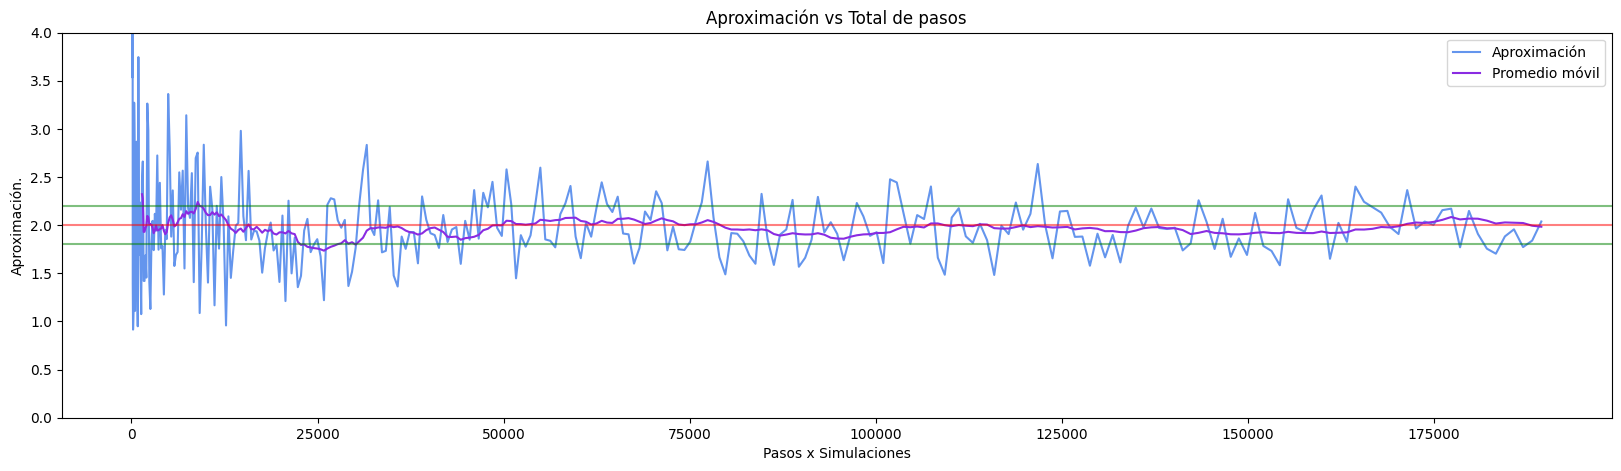

Aproximación promedio móvil: 1.9846143591710181
Diferencia con teórico: 0.015


In [ ]:
GraphQColorTest(3, 2, 300, 2, 0.1, ylimit=[0, 4]) # Note que el valor teórico es 2

En este caso se ve como la aproximación(linea azul) es muy mala para un numero bajo de pasos $\times$ simulaciones, per mejora considerablemente cuanto mas crecen estos valores. Adicionalmente, el promedio móvil se va acercando rápidamente al valor correcto y se mantiene dentro de la cota de error que es este caso es de $0.1$. En este caso, la aproximación del promedio móvil es bastante buena, con un error de apenas 0.011. Veamos como se comporta con otros valores:

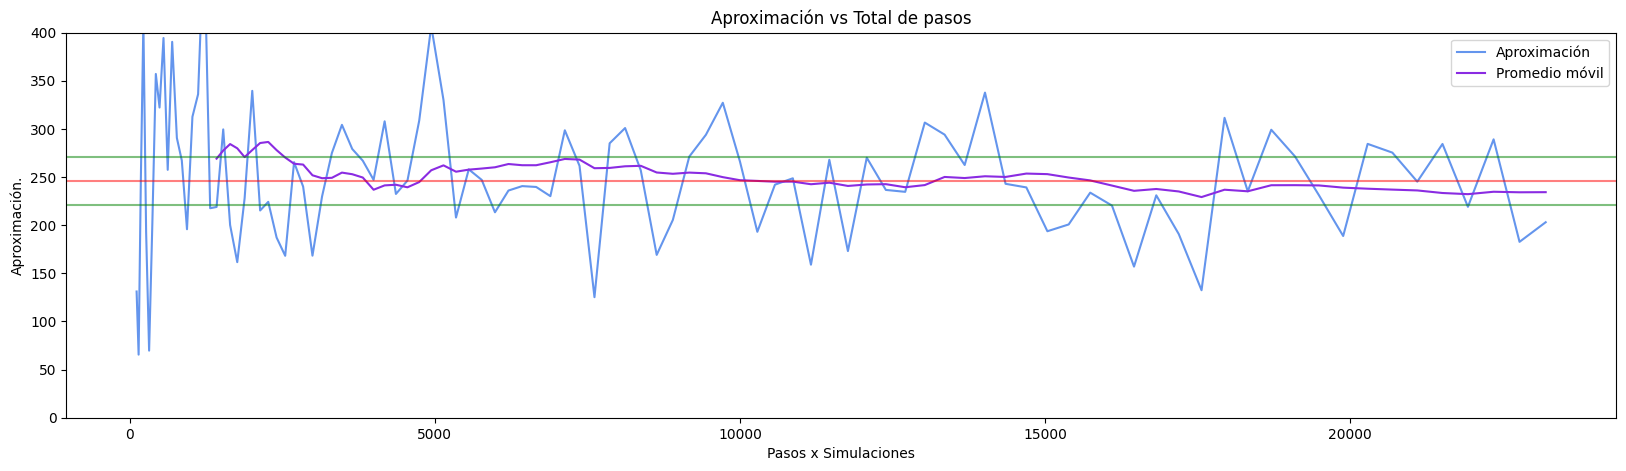

Aproximación promedio móvil: 234.3386278371213
Diferencia con teórico: 11.661


In [ ]:
GraphQColorTest(3, 3, 100, 246, 0.1, ylimit=[0, 400]) #Note que el valor teórico es 246

Veamos ahora con mas pasos

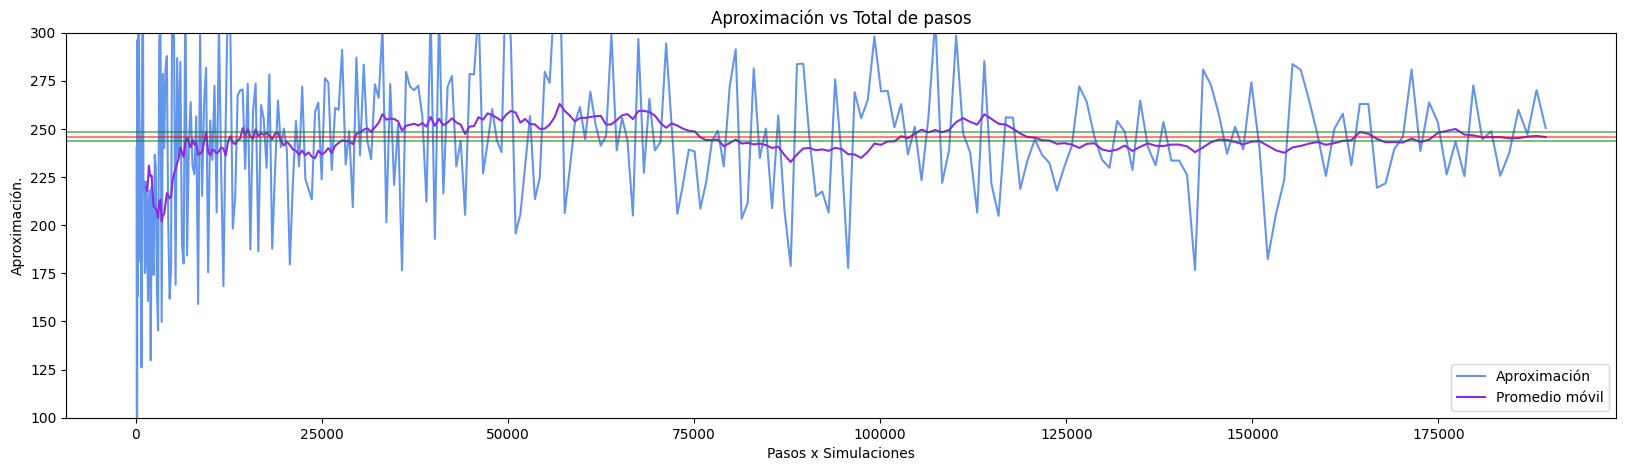

Aproximación promedio móvil: 245.77713430943436
Diferencia con teórico: 0.223


In [ ]:
GraphQColorTest(3, 3, 300, 246, 0.01, ylimit=[100, 300]) #Note que el valor teórico es 246

Vemos como comparado con el caso anterior, el error se reduce considerablemente. Esta ultima gráfica trunca el eje $y$ para ver mas cerca de el valor teórico, sin embargo nótese como en cuando los pasos y simulaciones son pequeños, las aproximaciones tanto puntual como móvil son bastante malas

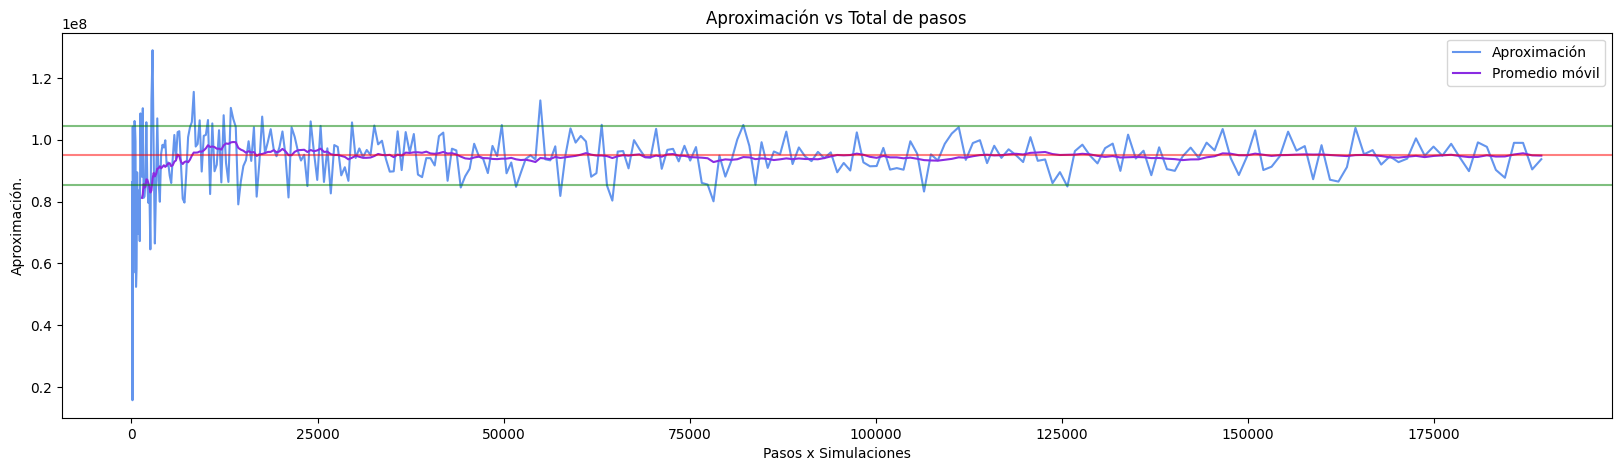

Aproximación promedio móvil: 94877003.24244824
Diferencia con teórico: 127068.758


In [ ]:
GraphQColorTest(3, 9, 300, 95004072, 0.1) # Note que el valor teórico es 95004072

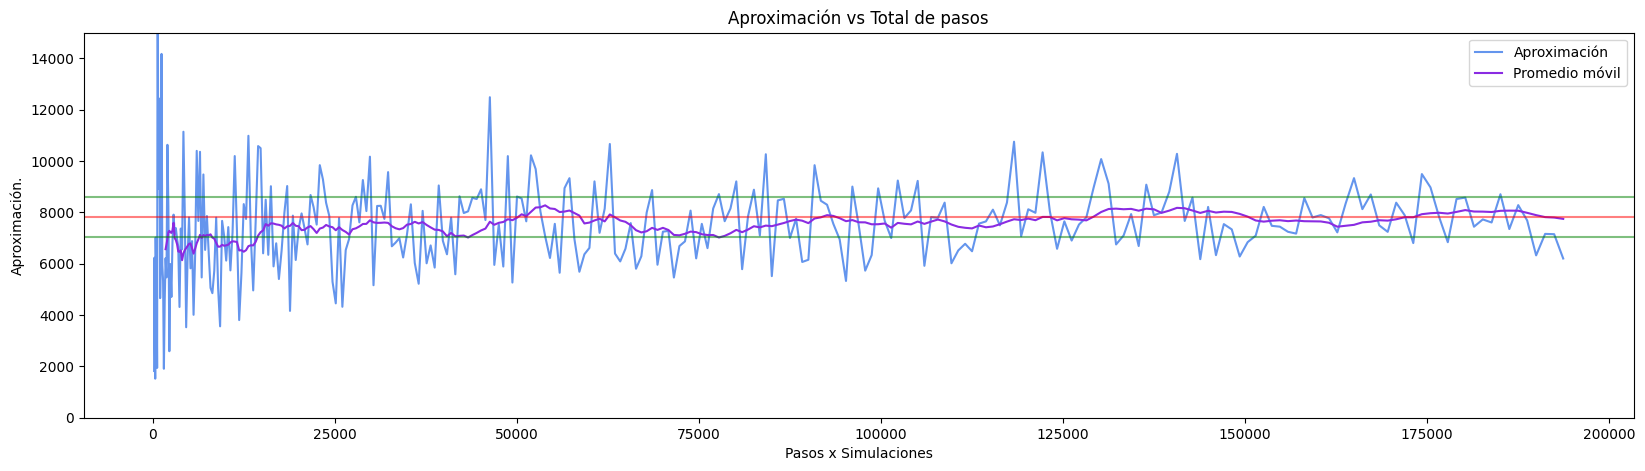

Aproximación promedio móvil: 7746.891396874043
Diferencia con teórico: 65.109


In [ ]:
GraphQColorTest(4, 3, 300, 7812, 0.1, ylimit=[0, 15000]) # Note que el valor teórico es 7812

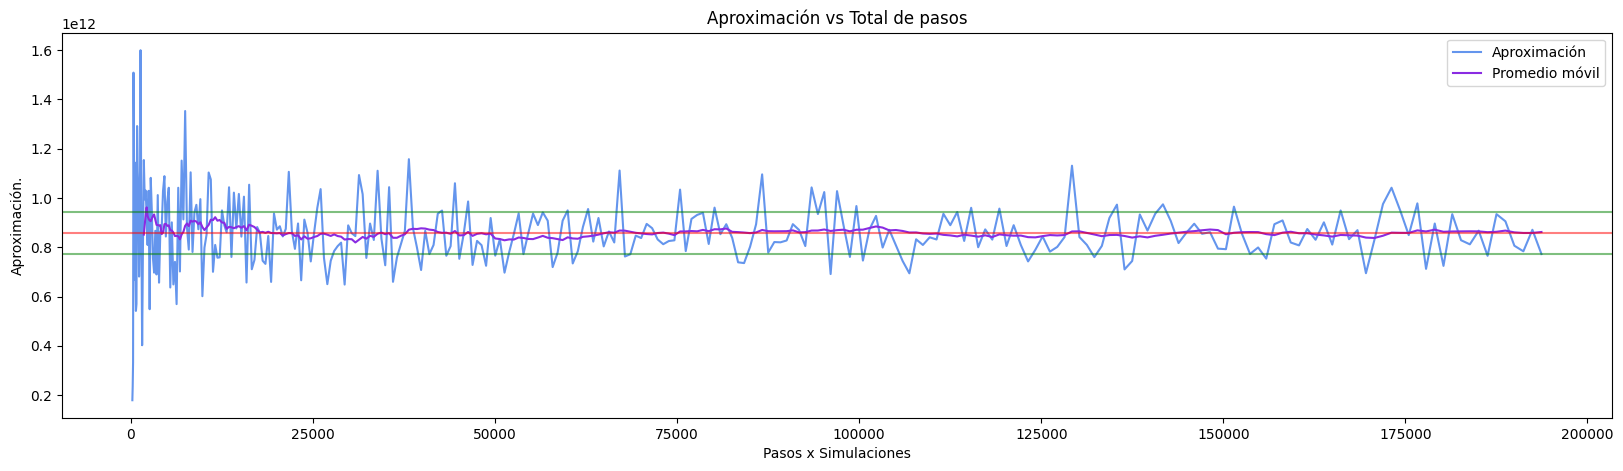

Aproximación promedio móvil: 861942416911.9343
Diferencia con teórico: 5083662859.934


In [ ]:
GraphQColorTest(4, 7, 300, 856858754052, 0.1) # Note que el valor teórico es 856858754052

Luego de evidenciar el buen desempeño para estos valores relativamente bajos vamos a probar con valores más alto.

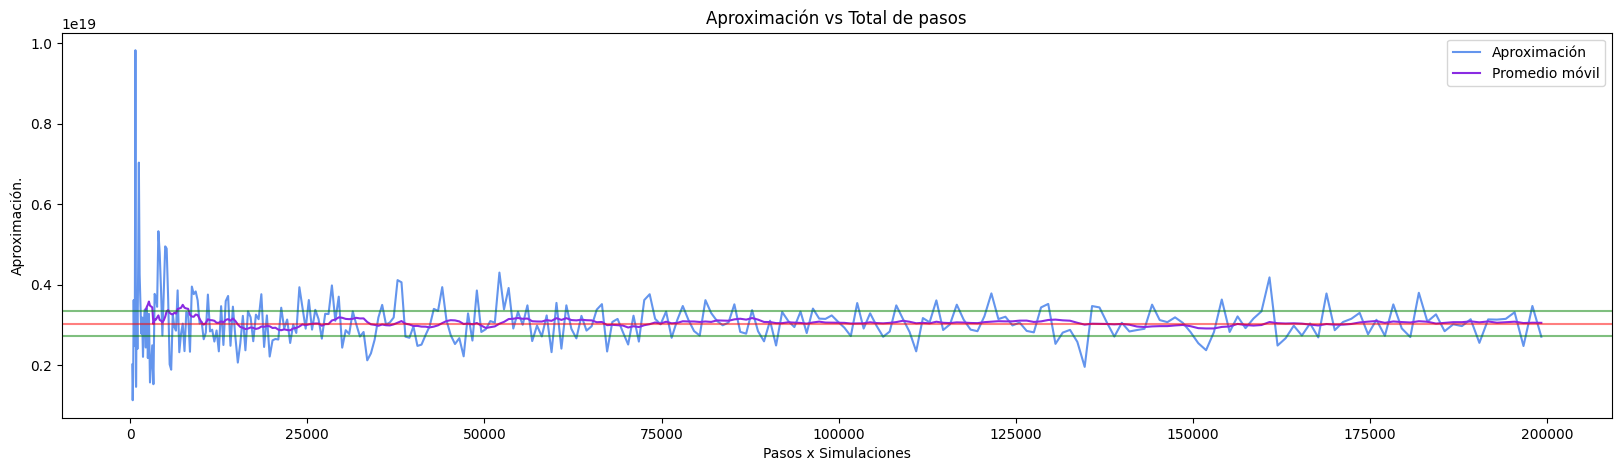

Aproximación promedio móvil: 3.05251076635846e+18
Diferencia con teórico: 2.073392227820237e+16


In [ ]:
GraphQColorTest(5, 7, 300, 3031776844080257742, 0.1) # Note que el valor teórico es 3031776844080257742

En el siguiente caso no pudimos obtener el valor teórico.

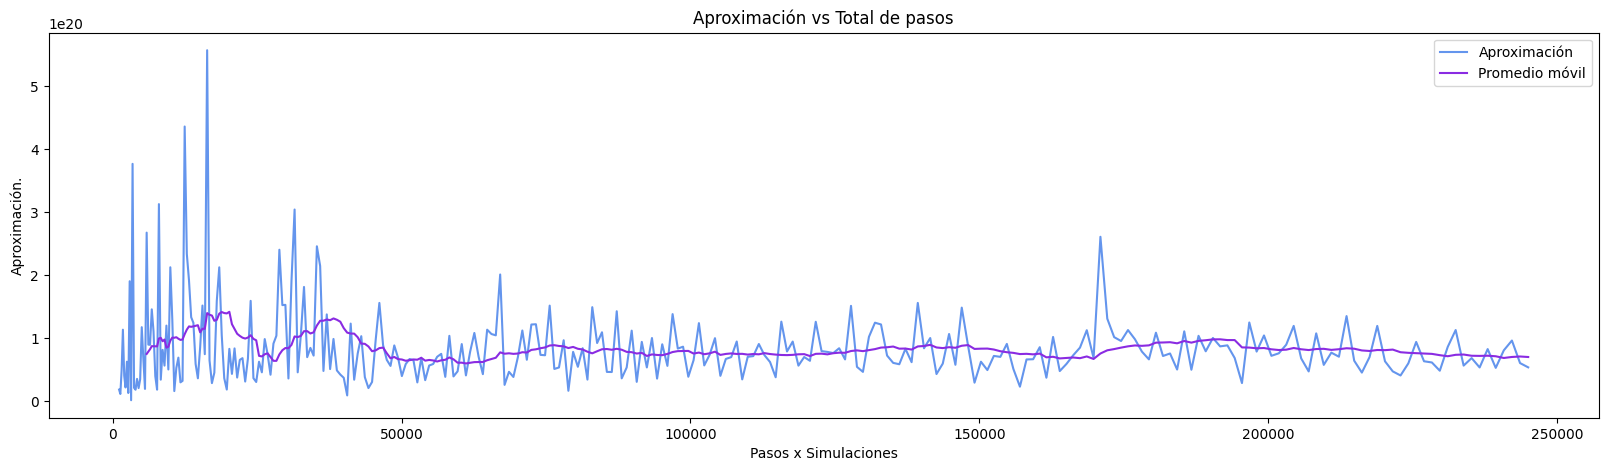

Aproximación promedio móvil: 6.983761599170498e+19


In [ ]:
GraphQColorTest(10, 3, 300)

Para el segundo experimento vamos a calcular varias predicciones para una cantidad de pasos y simulaciones fijas pero de un orden más alto.

In [ ]:
def findConstQColorFix(k, q, amount):
  l = k*k

  steps = int((l)*(math.log(l) + math.log(100))) # Con e = 0.01 y l = k*k
  sims =  (l**3) # Con l = k*k

  tries = [] # Guardamos el total de pasos*simulaciones
  results = [] # Guardamos las aproximaciones

  for i in range(amount):
    num = Experiment(k, q, steps, sims) # Guardamos los resultados
    tries.append(i)

    results.append(num)

  return tries, results


Note que la cantidad de pasos y simulaciones aquí ya es bastante grande y depende del tamaño del lattice, pero a diferencia del experimento anterior aquí la línea amarilla se mantiene en el área de errror

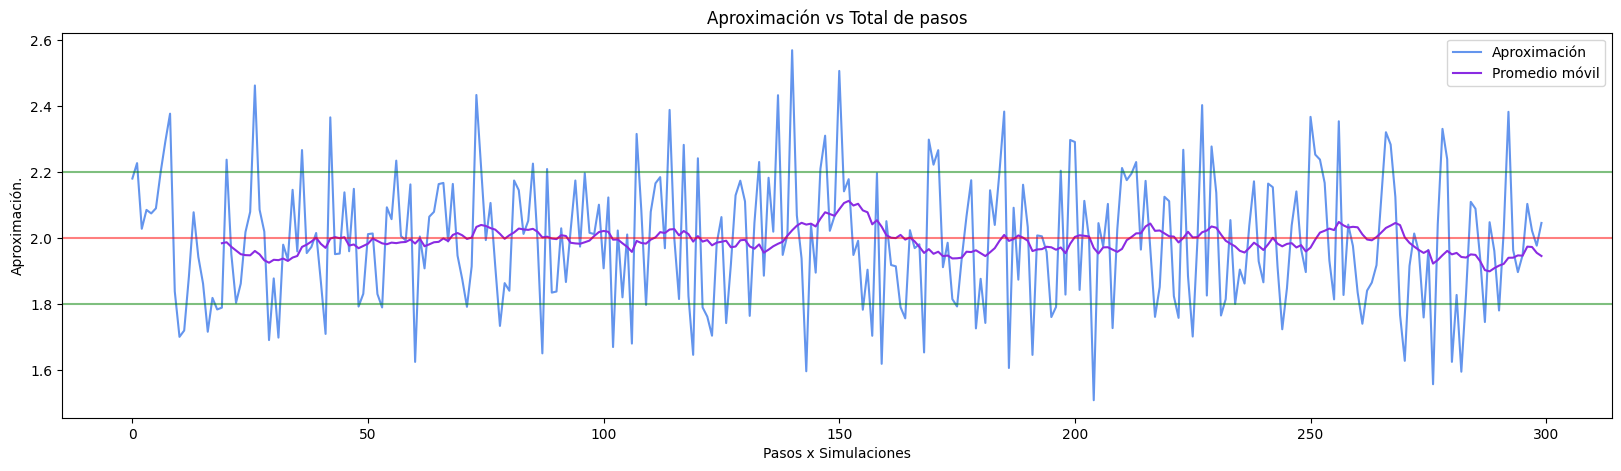

Aproximación promedio móvil: 1.946390392813165
Diferencia con teórico: 0.054


In [ ]:
GraphQColorTest(3, 2, 300, 2, 0.1, callback = findConstQColorFix) # Note que el valor teórico es 2

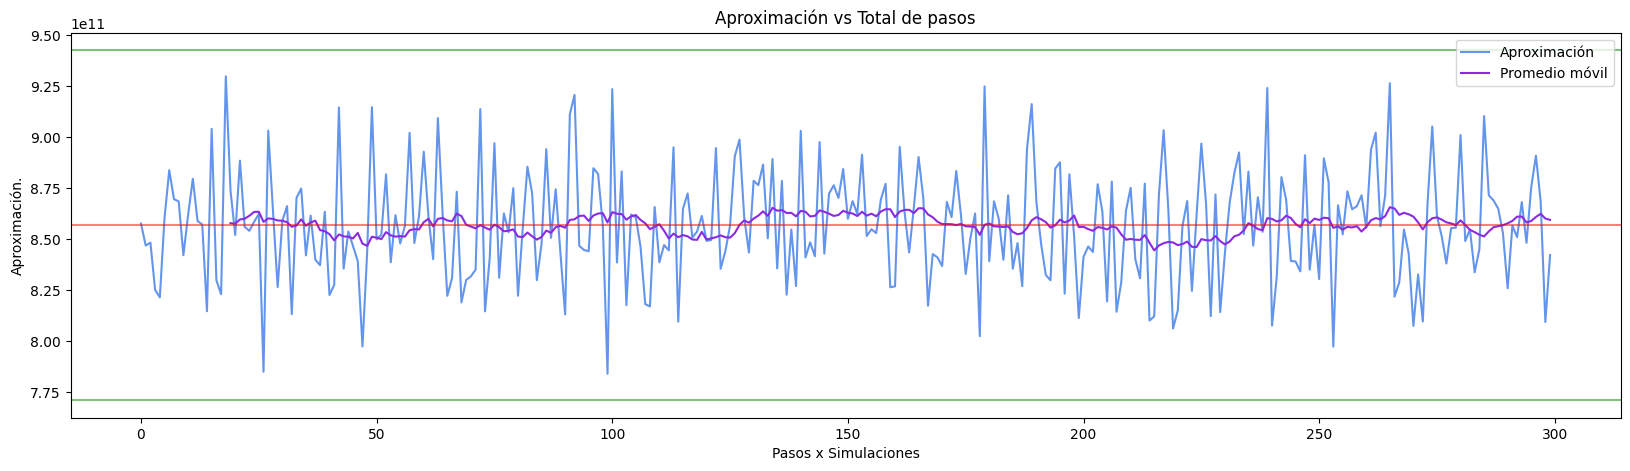

Aproximación promedio móvil: 859473139240.7087
Diferencia con teórico: 2614385188.709


In [ ]:
GraphQColorTest(4, 7, 300, 856858754052, 0.1, callback=findConstQColorFix) # Note que el valor teórico es 856858754052

Así, nuestros experimentos dan los siguientes resultados:

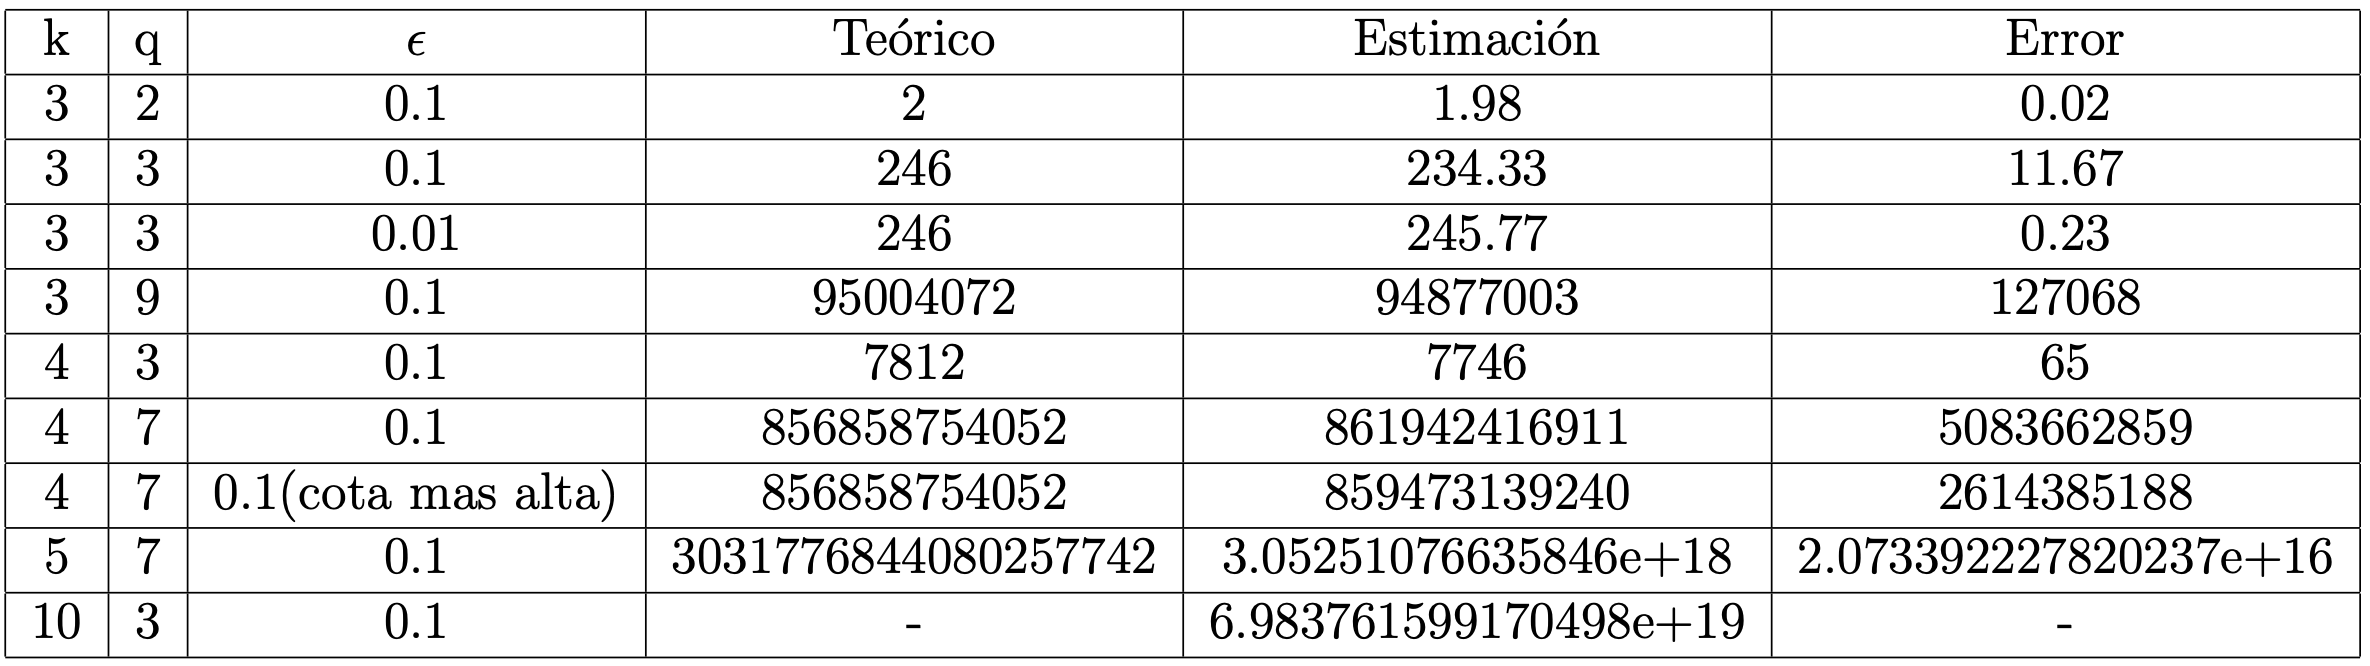

Vemos como para grafos pequeños la aproximación es bastante buena, aunque para grafos mas grandes el error es considerable, sin embargo esto es esperado, ya que para estos últimos la cota es muchísimo mas alta y en estos experimentos se probaron cotas mucho mas bajas. De igual manera se ve que para grafos grandes la tendencia del promedio móvil sigue siendo la de acercarse al valor teórico.

# Punto 2


Similar al ejercicio anterior necesitamos crear varias funciones solo que ahora vamos a tener en cuenta el modelo hard-core, es decir el systematic Gibbs, el verificador,

In [ ]:
def sysGibbsHardcore(k, steps, edges):# k * k matriz, 'n' steps, conjunto de aristas, colores
  n = k * k
  g = []
  hc = []
  # Inicializamos el grafo en blanco
  for i in range(n):
    g.append([])  # No tiene nodos adyacentes
    hc.append(0) # 0 para representar que el nodo no esta coloreado

  # Creamos el grafo con las aristas: Lista de adyacencias
  for e in edges:
    g[e[0]].append(e[1])
    g[e[1]].append(e[0])

  # Hacemos los steps
  for u in range(steps):
    if (bool(random.randrange(2))): # Arrojamos moneda
      hc[u % n] = 1 # Se pinta de negro
      for v in g[u % n]:
        if (hc[v] == 1):
          hc[u % n] = 0 # Se pinta de blanco en caso de que algún vecino esté de negro
    else:
      hc[u % n] = 0 # Tiene un 50% de ser pintado de blanco

  return hc

In [ ]:
def hCoreCheck(hc, edges):
  for e in edges: #Solo miramos los vertices conectados
    if ((hc[e[0]] == 1) and (hc[e[1]] == 1)): #Si ambas están pintadas de negro
      return False

  return True #De lo contrario True

In [ ]:
def GenCheckHC(k, steps, sims, edgb, edga):
  v = 0; # Llevamos el conteo de las muestras que pasan el test

  for u in range(sims): # Realizamos las simulaciones
    if (hCoreCheck( sysGibbsHardcore(k, steps, edgb), edga)): # Generamos una muestra con unas aristas y la evaluamos con una arista adicional
      v = v + 1

  return v/sims # Promedio de muestras que pasaron el test

In [ ]:
def ExperimentHC(k, steps, sims):
  l = k*k # Total de vertices
  m = 2*(k-1)*k; # Calculamos cuantas aristas hay para saber la cantidad de generaciones
  edgf = edgGen(k); # Generamos las aristas del lattice
  prom = 1

  for i in range(m): # Pasos sobre las aristas
    a = GenCheckHC(k, steps, sims, edgf[0:i], edgf[0:i+1])

    prom = prom * a # Se multiplica el resultado de las generaciones cumulativamente

  return prom*(2**l)

De forma similar al punto anterior primero vamos a realizar un análisis con valores pequeños de simulaciones y pasos que subirán poco a poco para observar hasta qué punto es realmente necesario aumentar la cantidad de simulaciones y pasos.

In [ ]:
def findConstHCore(k, amount):
  flag = False
  const_1 = 1 # Similar al punto anterior definimos un valor para las constantes
  const_2 = 1

  l = k*k

  steps = k*k
  sims =  10

  tries = []
  results = []

  while(not flag):

    t_steps = steps + (const_1) #Sumamos a los pasos y simulaciones las constantes
    t_sims = sims + (const_2)

    num = ExperimentHC(k, t_steps, t_sims) #Guardamos la predicción
    tries.append(t_steps*t_sims) #Guardamos los valores con los que se intentarob
    results.append(num)

    if(len(tries) > amount):
      flag = True

    const_1 += 1
    const_2 += 2

  return tries, results


In [ ]:
def GraphHCoreTest(k, amount):
  x, y = findConstHCore(k, amount)

  df = pd.DataFrame({'Const':x, 'Approx':y})
  df['Moving Average'] = df['Approx'].rolling(window=20).mean()

  df.plot(x='Const', y=['Approx', 'Moving Average'], figsize=(20,5))


  plt.xlabel('Steps x Sims')
  plt.ylabel('Approx.')
  plt.title('Aproximación vs Total de pasos')


  plt.show()
  print("Aproximación: ", df.iloc[-1]['Moving Average'])

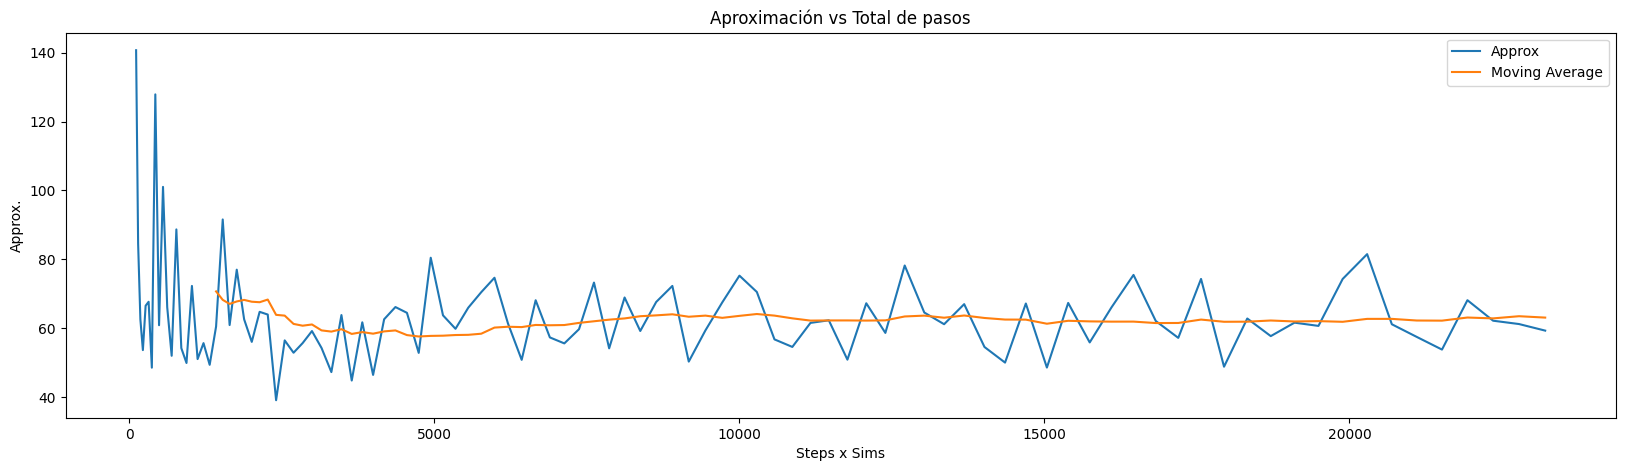

Aproximación:  63.06548833131701


In [ ]:
GraphHCoreTest(3, 100)

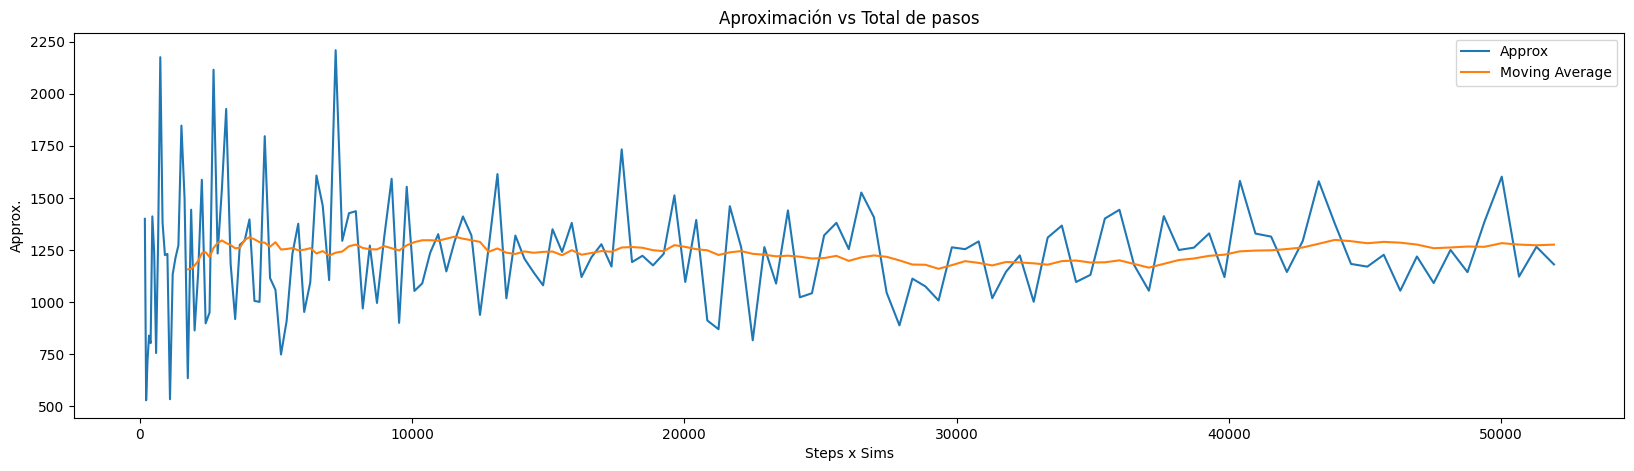

Aproximación:  1275.6051602232997


In [ ]:
GraphHCoreTest(4, 150)

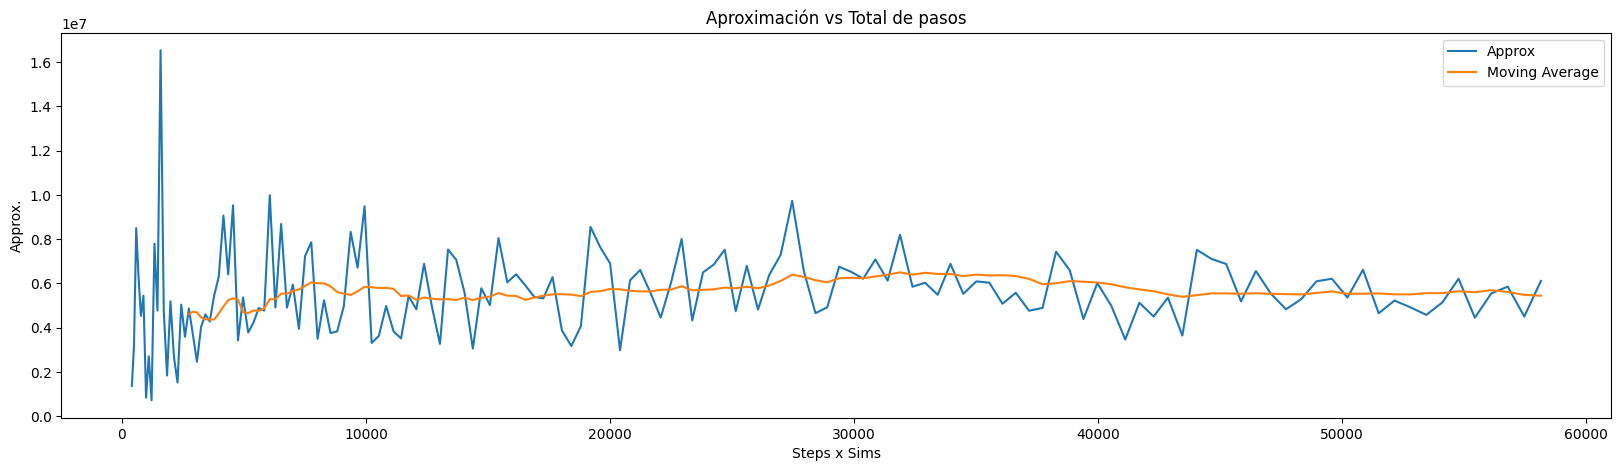

Aproximación:  5446248.611360054


In [ ]:
GraphHCoreTest(6, 150)

Podemos notar entonces que similar al ejercicio anterior las predicciones comienzan a variar cada vez menos con respecto a una recta, vamos entonces a realizar el experimento con una cantidad de pasos y simulaciones fijas lo suficientemente altas, para elegir una predicción precisa.

In [ ]:
def findConstHCoreFix(k, amount):

  l = k*k

  steps = int((l)*(math.log(l) + math.log(10))) #Con e = 0.1 y l = k*k
  sims =  (l**3)

  tries = []
  results = []

  for i in range(amount):

    num = ExperimentHC(k, steps, sims) #Guardamos la predicción
    tries.append(i) #Guardamos los valores con los que se intentarob
    results.append(num)


  return tries, results

def GraphHCoreTestFix(k, amount):
  x, y = findConstHCoreFix(k, amount)

  df = pd.DataFrame({'Const':x, 'Approx':y})
  df['Moving Average'] = df['Approx'].rolling(window=20).mean()

  df.plot(x='Const', y=['Approx', 'Moving Average'], figsize=(20,5))


  plt.xlabel('Steps x Sims')
  plt.ylabel('Approx.')
  plt.title('Aproximación vs Total de pasos')


  plt.show()
  print("Aproximación: ", df.iloc[-1]['Moving Average']) #Imprimimos el último promedio, la "mejor" predicción

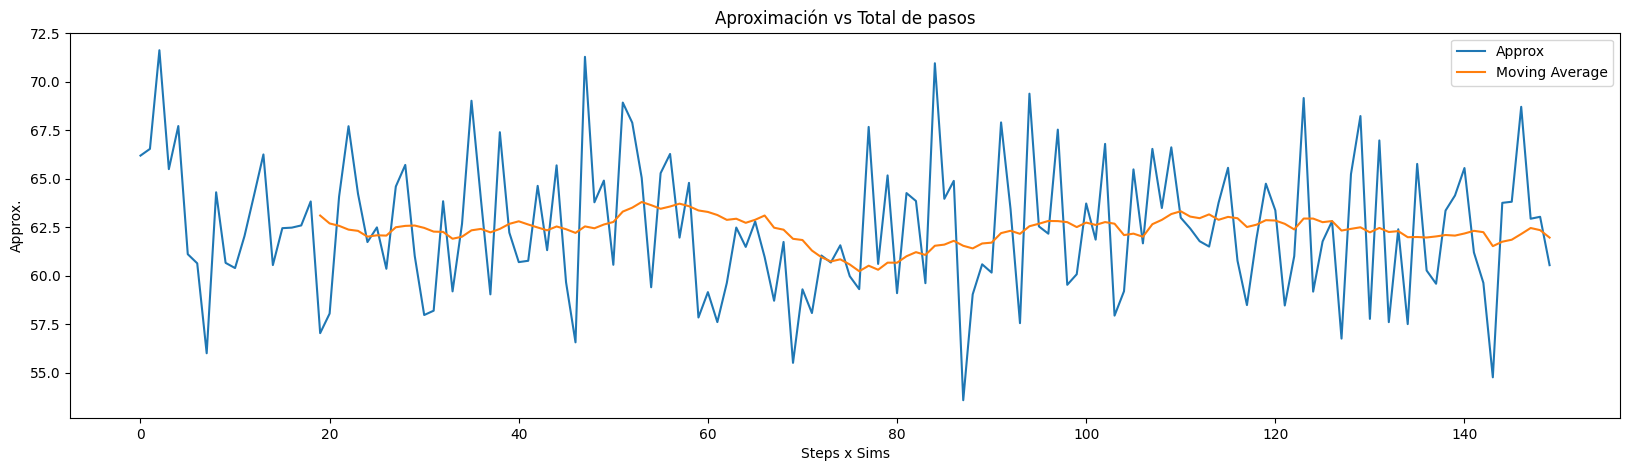

Aproximación:  61.97009417227058


In [ ]:
GraphHCoreTestFix(3, 150)

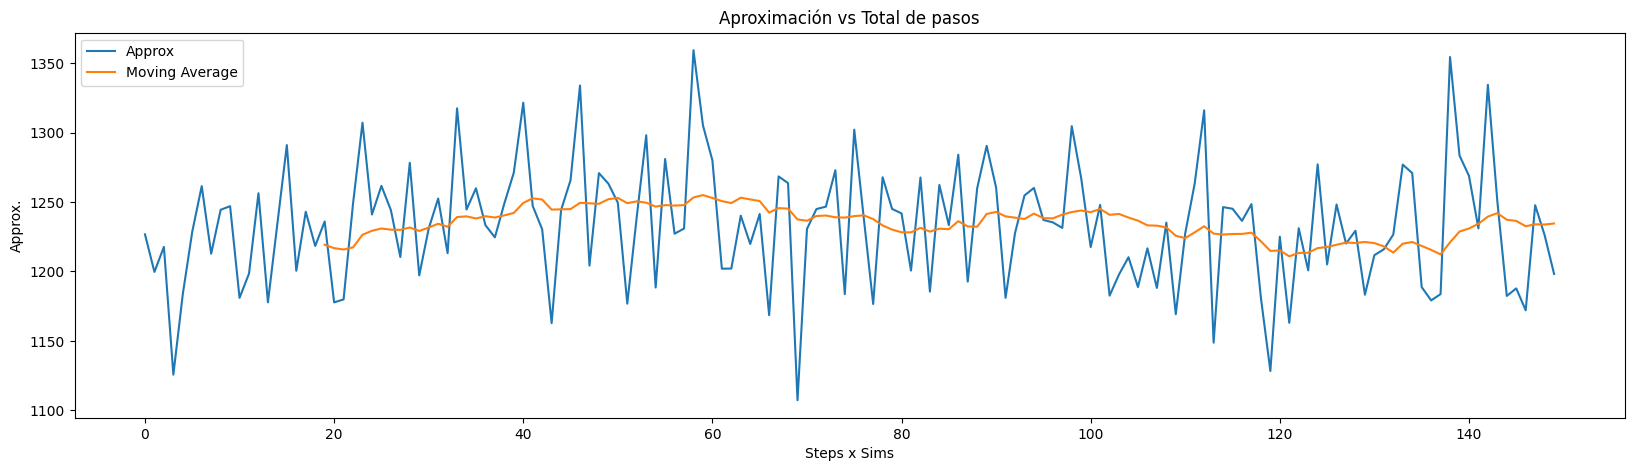

Aproximación:  1234.5576925809173


In [ ]:
GraphHCoreTestFix(4, 150)